# Prediction of Arrival Time in an E-Commerce
### Author: Data Squad
### Description: Shipment arrival prediction using machine learning algorithm
### Dataset: https://www.kaggle.com/prachi13/customer-analytics 
### Outline:
1. Data Extraction
2. Exploratory Data Analysis
3. Data Preparation
4. Model Evaluation
5. Merging Prediction using "K-nearest Neighbor Hyperparameter Tuning with GridSearch" to Dataframe

### Objective:
Create a system to help predict and calculate late shipment automatically

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## 1. Data Extraction

In [2]:
data = pd.read_csv("data/Train.csv")

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


#### a. Data Exploration

The data contains the following information: ID: ID Number of Customers. Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E. Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road. Customer care calls: The number of calls made from enquiry for enquiry of the shipment. Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best). Cost of the product: Cost of the Product in US Dollars. Prior purchases: The Number of Prior Purchase. Product importance: The company has categorized the product in the various parameter such as low, medium, high. Gender: Male and Female. Discount offered: Discount offered on that specific product. Weight in gms: It is the weight in grams. Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
m = data.shape[0]
n = data.shape[1]

print("Number of rows: " + str(m))
print("Number of columns: " + str(n))

Number of rows: 10999
Number of columns: 12


#### b. Data Cleansing

In [6]:
# check missing values
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [7]:
# check duplicates
print("Number of duplicated data:", data.duplicated().sum())
print("Number of duplicated ID:", data["ID"].duplicated().sum())

Number of duplicated data: 0
Number of duplicated ID: 0


#### c. Features and Label

In [8]:
# drop id column 
data.drop(["ID"], axis = 1, inplace=True)

In [9]:
data_div = data.copy()

# converting
data_div['Reached.on.Time_Y.N'] = data_div['Reached.on.Time_Y.N'].astype('category')
data_div['Reached.on.Time_Y.N'].replace(1,'Not_On_Time', inplace=True)
data_div['Reached.on.Time_Y.N'].replace(0,'On_Time', inplace=True)

# separate features and target
label=data_div['Reached.on.Time_Y.N']
numericals = data_div.select_dtypes(include=['number'])
categoricals = data_div.drop(['Reached.on.Time_Y.N'], axis=1).select_dtypes(exclude=['number'])

print("\nlabel column:", label.name)
print("__________________________\n")
print("numerical columns:\n", numericals.columns)
print("__________________________\n")
print("categorical columns:\n", categoricals.columns)


label column: Reached.on.Time_Y.N
__________________________

numerical columns:
 Index(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms'],
      dtype='object')
__________________________

categorical columns:
 Index(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], dtype='object')


<font color="darkblue">
    <b><i>All features, except "ID", will be used to see the correlation and insights so there are no too many assumptions</i></b>
</font>

## 2. Exploratory Data Analysis

### 2.1 Descriptive Statistics

In [10]:
numericals.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000


In [11]:
categoricals.describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


<font color="darkblue">
    <b><i>There is a  significant difference between mean and median of 'Discount_offered' and 'Weight_in_gms' indicating skewed distribution</i></b>
</font>

### 2.2 Univariate Analysis

#### a. Countplot

In [12]:
label.value_counts()

Not_On_Time    6563
On_Time        4436
Name: Reached.on.Time_Y.N, dtype: int64

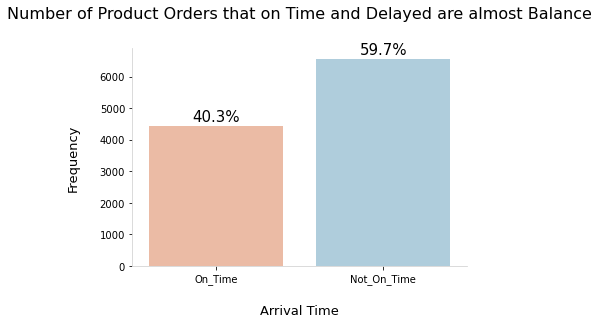

In [14]:
# plot
ax = sns.countplot(label, palette='RdBu')

total = float(len(label))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 150
    ax.annotate(percentage, (x, y), ha='center', fontsize=15)
    
# settings
plt.xlabel('Arrival Time', fontsize = 13, labelpad = 20)
plt.ylabel('Frequency', fontsize = 13, labelpad = 20)
plt.title('Number of Product Orders that on Time and Delayed are almost Balance', fontsize = 16, pad = 30)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

<font color="darkblue">
    <b><i>The graph above shows that arrival time categories that are 'On Time' and 'Not On Time' have an almost balanced order frequency</i></b>
</font>

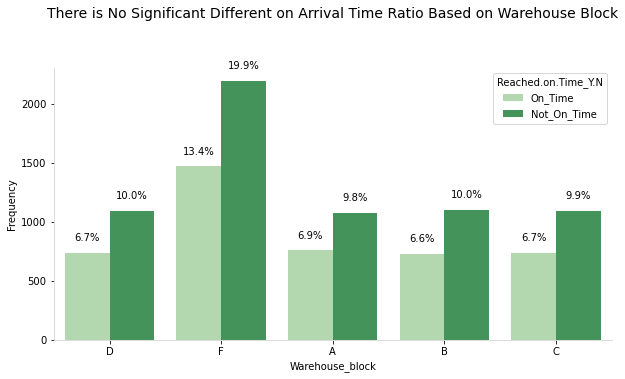

In [15]:
plt.figure(figsize=(10,5))

# plot
total = float(len(data_div)) 

ax = sns.countplot(x="Warehouse_block", data=data_div, hue='Reached.on.Time_Y.N', palette="Greens");
sns.despine(top=True, right=True, left=False, bottom=False);
ax.spines['left'].set_color('lightgray');
ax.spines['bottom'].set_color('lightgray');

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 100,
            '{0:.1%}'.format(height/total),
            ha="center", fontsize=10)
    
# settings 
ax.set_ylabel('Frequency');
# ax.set_title('Warehouse Block F has the Highest Number (19.9%)\nof Products that Arrive are Not On Time', fontsize = 14, pad = 50);
ax.set_title('There is No Significant Different on Arrival Time Ratio Based on Warehouse Block', fontsize = 14, pad = 50);

<font color="darkgreen">
    <ul><b><i>
        <li>ratio D: 1.49</li>
        <li>ratio F: 1.48</li>
        <li>ratio A: 1.42</li>
        <li>ratio B: 1.52</li>
        <li>ratio C: 1.47</li>
    </i></b></ul>
</font>

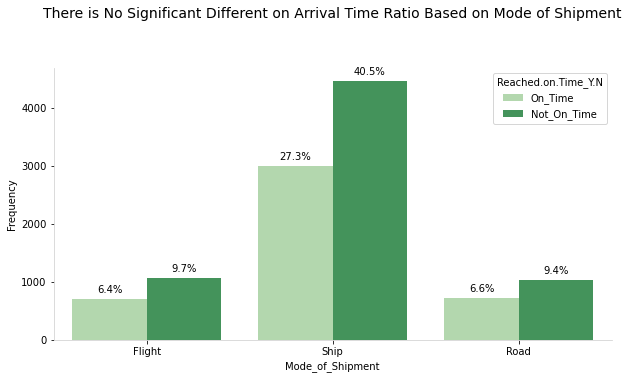

In [16]:
plt.figure(figsize=(10,5))

# plot
total = float(len(data_div)) 

ax = sns.countplot(x="Mode_of_Shipment", data=data_div, hue='Reached.on.Time_Y.N', palette="Greens");
sns.despine(top=True, right=True, left=False, bottom=False);
ax.spines['left'].set_color('lightgray');
ax.spines['bottom'].set_color('lightgray');

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 100,
            '{0:.1%}'.format(height/total),
            ha="center", fontsize=10)
    
# settings 
ax.set_ylabel('Frequency');
ax.set_title('There is No Significant Different on Arrival Time Ratio Based on Mode of Shipment', fontsize = 14, pad = 50);

<font color="darkgreen">
    <ul><b><i>
        <li>ratio Flight: 1.52</li>
        <li>ratio Ship: 1.48</li>
        <li>ratio Road: 1.42</li>
    </i></b></ul>
</font>

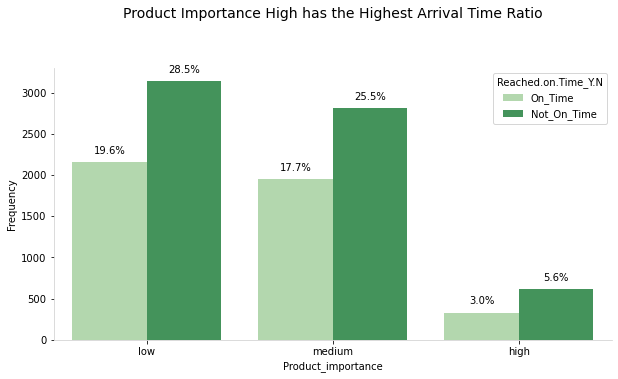

In [17]:
plt.figure(figsize=(10,5))

# plot
total = float(len(data_div)) 

ax = sns.countplot(x="Product_importance", data=data_div, hue='Reached.on.Time_Y.N', palette="Greens");
sns.despine(top=True, right=True, left=False, bottom=False);
ax.spines['left'].set_color('lightgray');
ax.spines['bottom'].set_color('lightgray');

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 100,
            '{0:.1%}'.format(height/total),
            ha="center", fontsize=10)
    
# settings 
ax.set_ylabel('Frequency');
ax.set_title('Product Importance High has the Highest Arrival Time Ratio', fontsize = 14, pad = 50);

<font color="darkgreen">
    <ul><b><i>
        <li>ratio low: 1.45</li>
        <li>ratio medium: 1.44</li>
        <li>ratio high: 1.87</li>
    </i></b></ul>
</font>

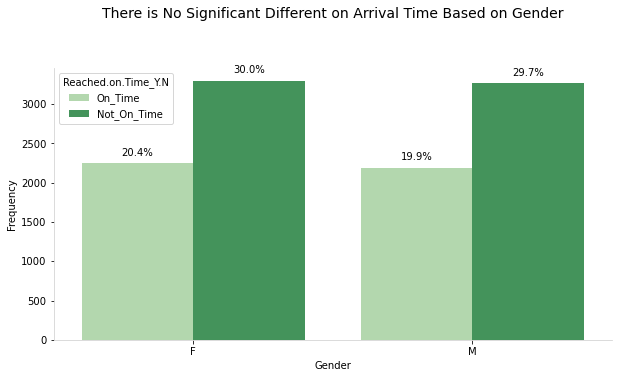

In [18]:
plt.figure(figsize=(10,5))

# plot
total = float(len(data_div)) 

ax = sns.countplot(x="Gender", data=data_div, hue='Reached.on.Time_Y.N', palette="Greens");
sns.despine(top=True, right=True, left=False, bottom=False);
ax.spines['left'].set_color('lightgray');
ax.spines['bottom'].set_color('lightgray');

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 100,
            '{0:.1%}'.format(height/total),
            ha="center", fontsize=10)
    
# settings 
ax.set_ylabel('Frequency');
ax.set_title('There is No Significant Different on Arrival Time Based on Gender', fontsize = 14, pad = 50);

<font color="darkgreen">
    <ul><b><i>
        <li>ratio female: 1.47</li>
        <li>ratio male: 1.49</li>
    </i></b></ul>
</font>

#### b. Boxplots

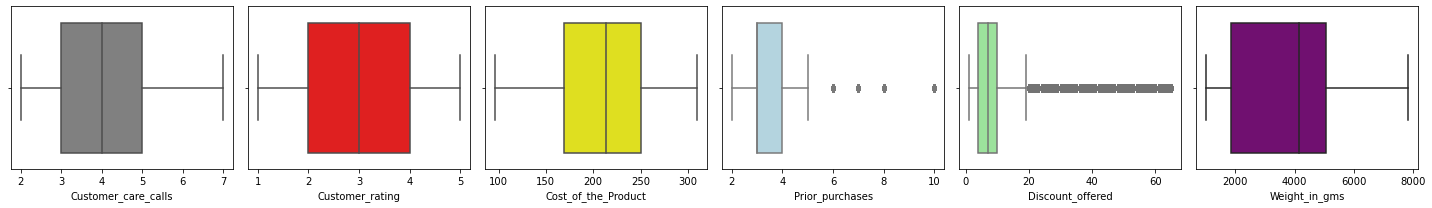

In [19]:
plt.figure(figsize=(20,3))
for i,colour in zip(range(0, len(numericals.columns)),['grey','red','yellow','lightblue','lightgreen','purple']):
    plt.subplot(1,len(numericals.columns),i+1)
    sns.boxplot(numericals[numericals.columns[i]], color=colour)
    plt.tight_layout()

<font color="darkblue">
    <ul><b><i>
        <li>The boxplot graphs above show that 'Prior_purchase' and 'Discount_offered' have a distribution affected by outliers shown on the graph. The outliers are piled up at the right end</li>
         <li>Weight_in_gms has an asymmetric distribution shown by median line that is not in the middle of interquartile range. However, there are no outliers on the graph. It may be affected by the number of modes that is more than 1 and imbalanced. The number of modes indicates there are different groups of Weight</li>
         <li>'Customer_care_calls','Customer_rating','Cost_of_the_Product' tend to have a normal distribution shown by median line in the midle of IQR</li>
    </i></b></ul>
</font>

#### c. Distplots

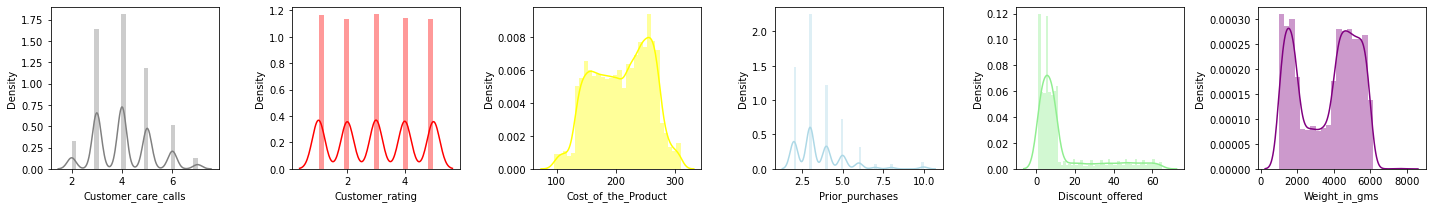

In [20]:
plt.figure(figsize=(20,3))
for i,colour in zip(range(0, len(numericals.columns)),['grey','red','yellow','lightblue','lightgreen','purple']):
    plt.subplot(1,len(numericals.columns),i+1)
    sns.distplot(numericals[numericals.columns[i]], color=colour)
    plt.tight_layout()

<font color="darkblue">
    <ul><b><i>
        <li>The distribution plots above show that 'Prior_purchase' and 'Discount_offered' have a skewed right (positively skewed) distribution where the data are piled up at the left end. There is a very small portion of the data collected on right side (outliers). It causes the mean > median</li>
         <li>Weight_in_gms has a bimodal distribution. It is affected by 2 imbalanced modes/peaks. It also indicates there are 2 different types of Weight</li>
         <li>'Customer_care_calls','Customer_rating','Cost_of_the_Product' tend to have a symmetric or normal distribution shown by nearly identical if folded in half at the center point of the distribution</li>
          <li>'Customer_rating' has a uniform distribution, the probabilities are exactly the same at each point, so the distribution is basically a straight line</li>
    </i></b></ul>
</font>

### 2.3 Multivariate Analysis

#### a. Pair Grid

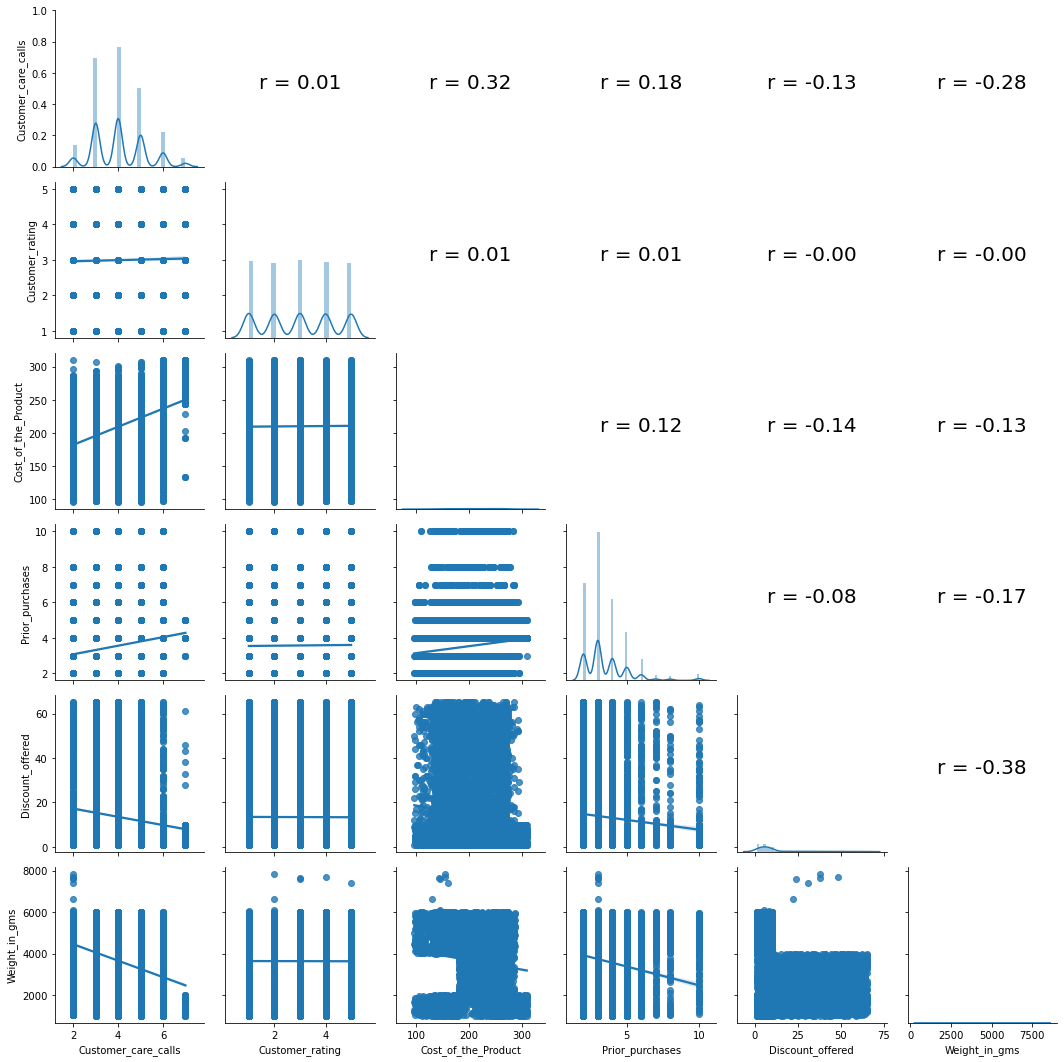

In [21]:
from scipy.stats import pearsonr

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size=20)
    ax.set_axis_off()

g = sns.PairGrid(data=numericals)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef);

<font color="darkblue">
    <ul><b><i>
        <li>There are no clear clusters shown on graph</li>
    </i></b></ul>
</font>

#### b. Pair plot + Hue

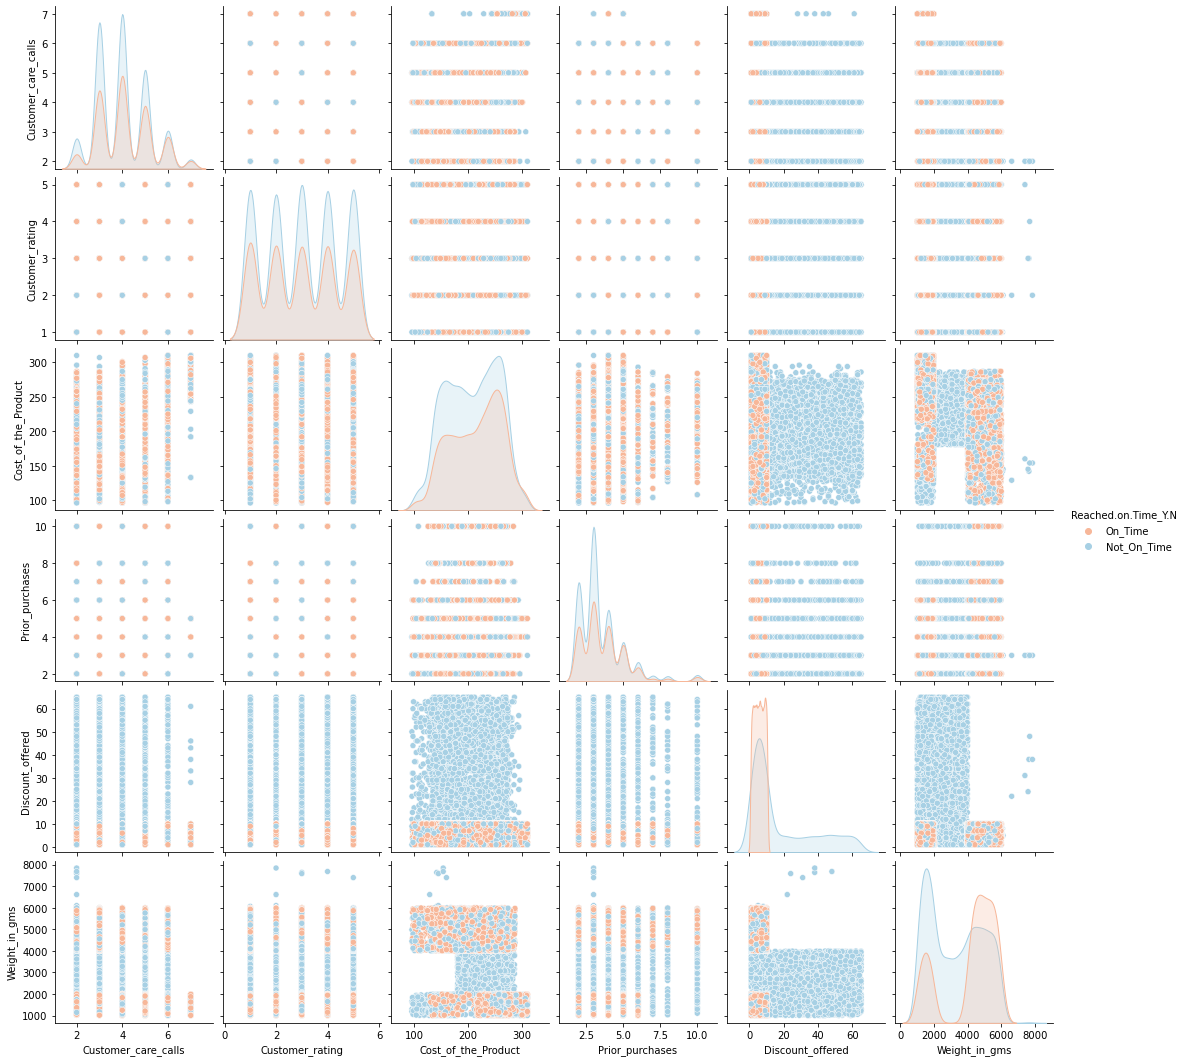

In [25]:
sns.pairplot(data=data_div, hue = "Reached.on.Time_Y.N", palette = "RdBu");

TypeError: 'AxesSubplot' object does not support item assignment

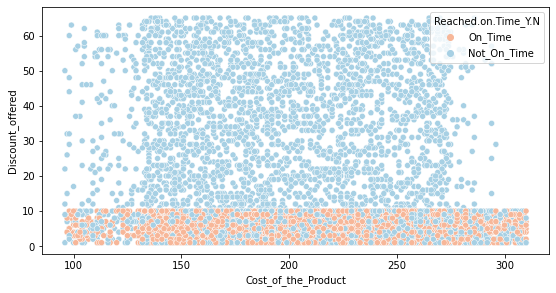

In [26]:
plt.figure(figsize=(20,10))

cols = ['Cost_of_the_Product','Weight_in_gms']
for i in range(len(cols)):
    plt.subplot(len(cols),2,i+1)
    ax[i] = sns.scatterplot(data=data_div, x=cols[i], y='Discount_offered', hue="Reached.on.Time_Y.N", palette = "RdBu")

    # settings
    sns.despine(top=True, right=True, left=False, bottom=False)
    ax[i].spines['left'].set_color('lightgray')
    ax[i].spines['bottom'].set_color('lightgray')
    ax[i].legend(loc=(0.2,1.1), ncol = 2, frameon=False)
    ax[i].set_xlabel(cols[i], fontsize = 13, labelpad = 20)
    ax[i].set_ylabel('Discount_offered', fontsize = 13, labelpad = 20)
    ax[0].text(0,1.6, 'We recommend to increase cooperation on shipping expeditions ', transform=ax[0].transAxes, fontsize=20, fontweight='bold')
    ax[0].text(0,1.5, 'to handle effect of price discount to the number of transactions and delivery delays', transform=ax[0].transAxes, fontsize=15)
    ax[0].text(0,1.3, 'Correlation of discount offered to product arrival time', transform=ax[0].transAxes, fontsize=17)
    ax[0].text(0.6,0.05, "Product orders that on time\ntend to have the lowest\n'Discount offered'", transform=ax[0].transAxes, color='#616161', fontsize=14)
    ax[1].text(0.6,0.5, "Product orders that not on time\ntend to have the highest\n'Discount offered'", transform=ax[1].transAxes, color='#616161', fontsize=14)
    ax[0].axhline(y=5, xmin=0.47, xmax=0.57, color='#616161', alpha=0.3)
    ax[1].axhline(y=40, xmin=0.47, xmax=0.57, color='#616161', alpha=0.3)
    ax[0].set_xlim([0, 700])

<font color="darkblue">
    <ul><b><i>
        <li>Product orders that on time tend to have the lowest 'Discount offered' and tend to have a highest and lowest 'Weight_in_gms'</li>
        <li>The on time and not on time categories on feature correlations between 'Discount_offered' and  the other features, as well as feature correlation between 'Weight_in_gms' and  the other features, tend to have well separated indicating a good combination of features</li>
    </i></b></ul>
</font>

#### c. Correlation Heatmap

In [12]:
# compute corr
numericals.corr(method = "pearson")

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Customer_care_calls,1.000000,0.012209,0.323182,0.180771,-0.130750,-0.276615
Customer_rating,0.012209,1.000000,0.009270,0.013179,-0.003124,-0.001897
Cost_of_the_Product,0.323182,0.009270,1.000000,0.123676,-0.138312,-0.132604
Prior_purchases,0.180771,0.013179,0.123676,1.000000,-0.082769,-0.168213
Discount_offered,-0.130750,-0.003124,-0.138312,-0.082769,1.000000,-0.376067
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.168213,-0.376067,1.000000


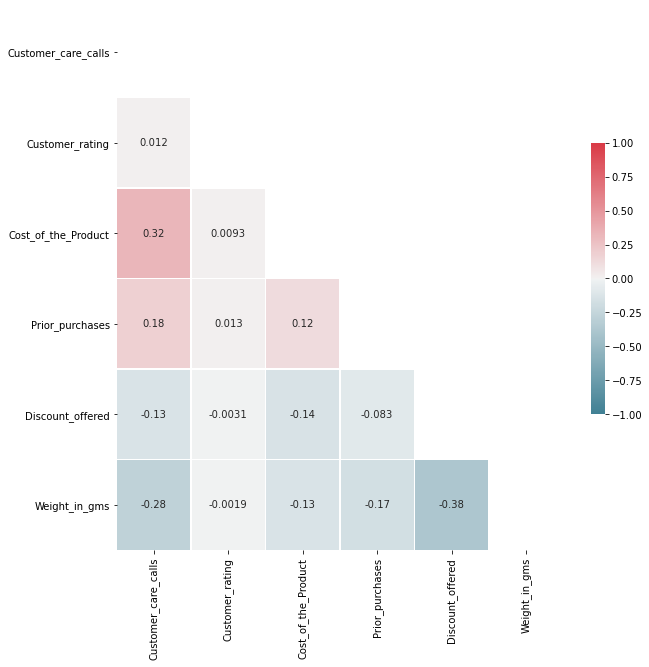

In [13]:
# compute correlation 
corr = numericals.corr(method = "pearson")

# mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# set figure size
f, ax = plt.subplots(figsize = (10,10))

# set colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, 
           vmin = -1, vmax = 1, center = 0,
           linewidths = .5, cbar_kws = {"shrink": .5}, annot = True);

<font color="darkblue">
    <ul><b><i>
        <li>There are no redundant features, no strong correlated features</li>
        <li>'Customer_care_calls' are positively correlated with 'Cost_of_the_Product' (r=0.32)</li>
        <li>There are negative correlation between 'Customer_care_calls' and 'Weight_in_gms' (r=-0.28), 'Discount_offered' and 'Weight_in_gms' (r=-0.38)</li>
    </i></b></ul>
</font>

## 3. Data Preparation

### 3.1 Normalisation/Standardisation

In [8]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [9]:
# Using standardisation for normal distribution assumption of data 

std_columns = ['Customer_care_calls','Customer_rating','Cost_of_the_Product']

data_clean = data.copy()

for i in std_columns:
    data_clean[i] = StandardScaler().fit_transform(data_clean[i].values.reshape(len(data_clean),1))

In [10]:
# Using normalisation for distribution that is not normal assumption 

norm_columns = ['Prior_purchases','Discount_offered','Weight_in_gms']

for i in norm_columns:
    data_clean[i] = MinMaxScaler().fit_transform(data_clean[i].values.reshape(len(data_clean),1))
    
data_clean.head(3)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,-0.047711,-0.700755,-0.690722,0.125,low,F,0.671875,0.033893,1
1,F,Flight,-0.047711,1.421578,0.120746,0.000,low,M,0.906250,0.304894,1
2,A,Flight,-1.799887,-0.700755,-0.565881,0.250,low,M,0.734375,0.346676,1


### 3.2 Feature Encoding

In [11]:
# One-hot Encoding
def onehot_encode(data, column):
    dummies = pd.get_dummies(data[column], prefix=column)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

for column in ['Warehouse_block','Mode_of_Shipment','Gender']:
        data_clean = onehot_encode(data_clean, column=column)

data_clean.head(2)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.047711,-0.700755,-0.690722,0.125,low,0.671875,0.033893,1,0,0,0,1,0,1,0,0,1,0
1,-0.047711,1.421578,0.120746,0.000,low,0.906250,0.304894,1,0,0,0,0,1,1,0,0,0,1


In [12]:
# Label Encoding
for column in ['Product_importance']:
        data_clean[column] = data_clean[column].astype('category').cat.codes

data_clean.head(2)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.047711,-0.700755,-0.690722,0.125,1,0.671875,0.033893,1,0,0,0,1,0,1,0,0,1,0
1,-0.047711,1.421578,0.120746,0.000,1,0.906250,0.304894,1,0,0,0,0,1,1,0,0,0,1


<font color="darkblue">
    <ul><b><i>
        <li>After finding out that the features have an distribution that are normal and not normal, a standardisation and normalisation process is carried out so that the learning algorithm treats all features fairly and makes it easier to interpret several ML models</li>
        <li>Then feature encoding is carried out so that all feature categories can be used for modeling</li>
    </i></b></ul>
</font>

## 4. Model Evaluation

<font color="darkblue">
    <ul><b><i>
        <li>We want to minimise the prediction that the product is delivered on time when in fact it is not on time, so we are going to focus on 'recall' (trying to minimise false negative) to evaluate the model performane</li>
    </i></b></ul>
</font>

In [13]:
# define functions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))


In [14]:
# separate features and target
X = data_clean.drop(columns=['Reached.on.Time_Y.N'], axis=1)
y = data_clean['Reached.on.Time_Y.N']

In [15]:
# Split into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
m = len(X)
m_train = len(X_train)
m_test = len(X_test)

print("Total Data = " + str(m))
print("Train Data = " + str(m_train))
print("Test Data = " + str(m_test))

Total Data = 10999
Train Data = 8799
Test Data = 2200


### 4.1 Logistic Regression

In [35]:
# Model Development

from sklearn.linear_model import LogisticRegression

modelLogisticRegression = LogisticRegression(random_state=42)
modelLogisticRegression.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [55]:
# Prediction Result (in data test)

y_pred = modelLogisticRegression.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 0, 0])

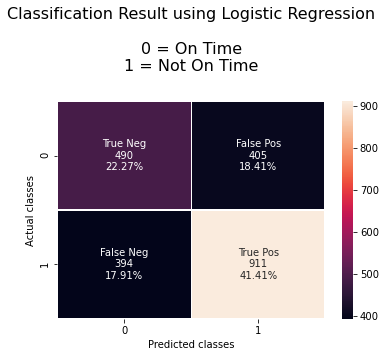

In [37]:
# Classification Result

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using Logistic Regression\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

In [56]:
# Model Evaluation

eval_classification(modelLogisticRegression, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.69
Recall (Test Set): 0.70
F1-Score (Test Set): 0.70
AUC: 0.62


In [72]:
y_pred_train = modelLogisticRegression.predict(X_train)

print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

Recall (Train Set): 0.69
Recall (Test Set): 0.70


#### Logistic Regression GridSearch

In [33]:
from sklearn.model_selection import GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
modelLogisticRegressionGrid = GridSearchCV(logres, hyperparameters, cv=5, scoring='recall')

# Fitting Model & Evaluation
modelLogisticRegressionGrid.fit(X_train, y_train)
y_pred = modelLogisticRegressionGrid.predict(X_test)
eval_classification(modelLogisticRegressionGrid, y_pred, X_train, y_train, X_test, y_test)

print('\n\nBest algorithm:', modelLogisticRegressionGrid.best_estimator_.get_params()['penalty'])
print('Best C:', modelLogisticRegressionGrid.best_estimator_.get_params()['C'])

Accuracy (Test Set): 0.59
Precision (Test Set): 0.59
Recall (Test Set): 1.00
F1-Score (Test Set): 0.74
AUC: 0.50


Best algorithm: l2
Best C: 0.0001


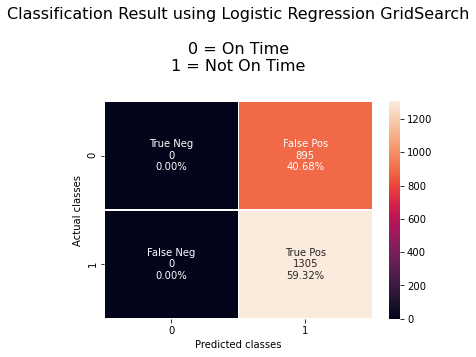

In [34]:
# Classification Result using Logistic Regression GridSearch

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using Logistic Regression GridSearch\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

<font color="darkblue">
    <ul><b><i>
        <li>Even though the recall value is perfect, 100%, the other evaluation metric values are very small and unbalanced as well where all the predicted results are not on time. We'll avoid an outcome like this.</li>
    </i></b></ul>
</font>

#### Precision-Recall Curves

Logistic: f1=0.695 auc=0.838


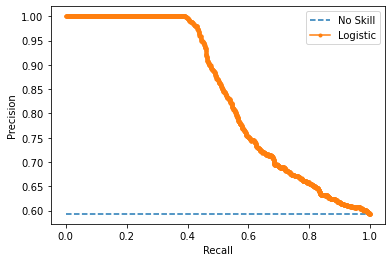

In [77]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = modelLogisticRegression.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = modelLogisticRegression.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show();

### 4.2 K-nearest Neighbor

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Inisiasi model
modelKNeighborsClassifier = KNeighborsClassifier()
modelKNeighborsClassifier.fit(X_train, y_train)

# Prediction & Evaluation
y_pred = modelKNeighborsClassifier.predict(X_test)
eval_classification(modelKNeighborsClassifier, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.65
Recall (Test Set): 0.67
F1-Score (Test Set): 0.66
AUC: 0.57


In [80]:
y_pred_train = modelKNeighborsClassifier.predict(X_train)

print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

Recall (Train Set): 0.81
Recall (Test Set): 0.67


<font color="darkblue">
    <ul><b><i>
        <li>there is overfitting where recall on train set > recall on test set</li>
    </i></b></ul>
</font>

#### K-nearest Neighbor Hyperparameter Tuning with RandomSearch

In [87]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform','distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

# Init model
knn = KNeighborsClassifier()
modelKNeighborsClassifierRdn = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall', n_iter=100)

# Fit Model & Evaluasi
modelKNeighborsClassifierRdn.fit(X_train, y_train)
y_pred = modelKNeighborsClassifierRdn.predict(X_test)
eval_classification(modelKNeighborsClassifierRdn, y_pred, X_train, y_train, X_test, y_test)

print('\n\nBest n_neighbors:', modelKNeighborsClassifierRdn.best_estimator_.get_params()['n_neighbors'])
print('Best p:', modelKNeighborsClassifierRdn.best_estimator_.get_params()['p'])
print('Best algorithm:', modelKNeighborsClassifierRdn.best_estimator_.get_params()['algorithm'])

Accuracy (Test Set): 0.61
Precision (Test Set): 0.64
Recall (Test Set): 0.80
F1-Score (Test Set): 0.71
AUC: 0.57


Best n_neighbors: 29
Best p: 2
Best algorithm: brute


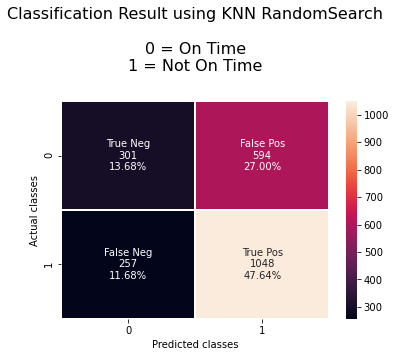

In [193]:
# Classification Result using KNN RandomSearch

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using KNN RandomSearch\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

#### K-nearest Neighbor Hyperparameter Tuning with GridSearch

In [18]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# List of hyperparameter
n_neighbors = list(range(1,40))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform','distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

# Init model
knn = KNeighborsClassifier()
modelKNeighborsClassifierGrid = GridSearchCV(knn, hyperparameters, cv=5, scoring='recall')

# Fit Model & Evaluasi
modelKNeighborsClassifierGrid.fit(X_train, y_train)
y_pred_knnG = modelKNeighborsClassifierGrid.predict(X_test)
eval_classification(modelKNeighborsClassifierGrid, y_pred_knnG, X_train, y_train, X_test, y_test)

print('\n\nBest n_neighbors:', modelKNeighborsClassifierGrid.best_estimator_.get_params()['n_neighbors'])
print('Best p:', modelKNeighborsClassifierGrid.best_estimator_.get_params()['p'])
print('Best algorithm:', modelKNeighborsClassifierGrid.best_estimator_.get_params()['algorithm'])

Accuracy (Test Set): 0.61
Precision (Test Set): 0.63
Recall (Test Set): 0.83
F1-Score (Test Set): 0.72
AUC: 0.56


Best n_neighbors: 39
Best p: 2
Best algorithm: auto


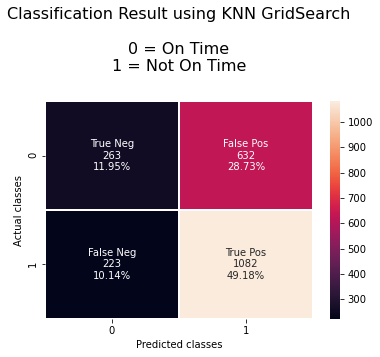

In [20]:
# Classification Result using KNN GridSearch

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred_knnG)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using KNN GridSearch\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

<font color="darkblue">
    <ul><b><i>
        <li>The recall score (83%) is good enough and the other metric values are not too imbalanced</li>
    </i></b></ul>
</font>

### 4.3 Decision Tree

In [196]:
from sklearn.tree import DecisionTreeClassifier

# Inisiasi model
modelDecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
modelDecisionTreeClassifier.fit(X_train,y_train)

# Prediction & Evaluation
y_pred = modelDecisionTreeClassifier.predict(X_test)
eval_classification(modelDecisionTreeClassifier, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.70
Recall (Test Set): 0.71
F1-Score (Test Set): 0.70
AUC: 0.63


In [197]:
y_pred_train = modelDecisionTreeClassifier.predict(X_train)

print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

Recall (Train Set): 1.00
Recall (Test Set): 0.71


<font color="darkblue">
    <ul><b><i>
        <li>there is overfitting where recall on train set > recall on test set</li>
    </i></b></ul>
</font>

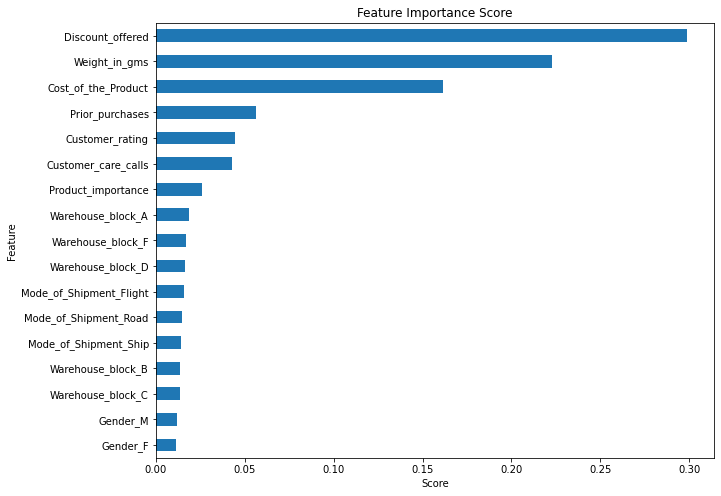

In [198]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

show_feature_importance(modelDecisionTreeClassifier)

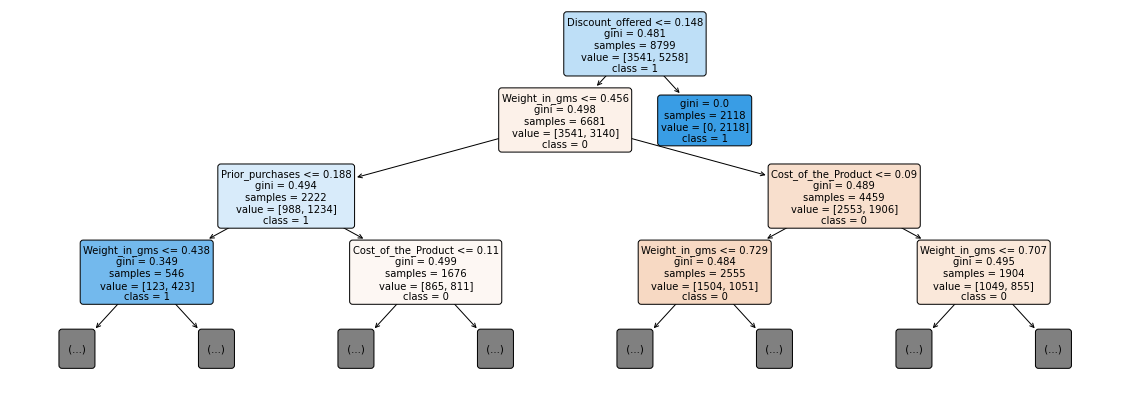

In [199]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(20, 7))
tree.plot_tree(modelDecisionTreeClassifier,
               feature_names = X.columns.tolist(), 
               class_names=['0','1'],
               filled = True, fontsize=10, rounded=True, max_depth=3)
plt.show()

#### Decision Tree Hyperparameter Tuning with GridSearch

In [200]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
modelDecisionTreeClassifierGrid = GridSearchCV(dt, hyperparameters, cv=5, scoring='recall')
modelDecisionTreeClassifierGrid.fit(X_train, y_train)

# Predict & Evaluation
y_pred = modelDecisionTreeClassifierGrid.predict(X_test)#Check performa dari model
eval_classification(modelDecisionTreeClassifierGrid, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.59
Recall (Test Set): 1.00
F1-Score (Test Set): 0.74
AUC: 0.50


In [220]:
print('Best max_depth:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['max_features'])
print('Best criterion:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['criterion'])
print('Best splitter:', modelDecisionTreeClassifierGrid.best_estimator_.get_params()['splitter'])

Best max_depth: 1
Best min_samples_split: 2
Best min_samples_leaf: 1
Best max_features: auto
Best criterion: gini
Best splitter: random


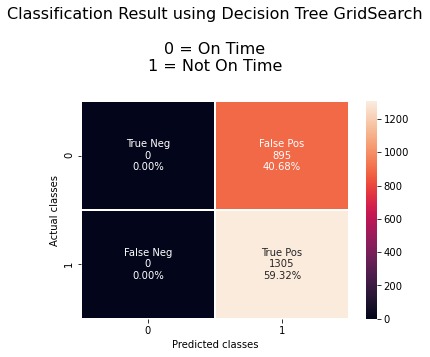

In [201]:
# Classification Result using Decision Tree GridSearch

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using Decision Tree GridSearch\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

<font color="darkblue">
    <ul><b><i>
        <li>Even though the recall value is perfect, 100%, the other evaluation metric values are very small and unbalanced as well where all the predicted results are not on time. We'll avoid an outcome like this.</li>
    </i></b></ul>
</font>

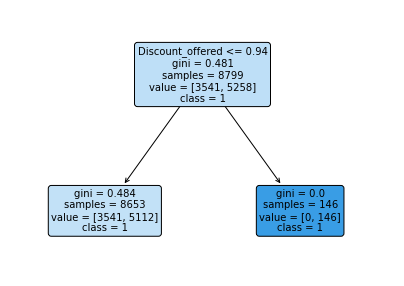

In [204]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(7, 5))
tree.plot_tree(modelDecisionTreeClassifierGrid.best_estimator_,
               feature_names = X.columns.tolist(), 
               class_names=['0','1'],
               filled = True, fontsize=10, rounded=True)
plt.show()

#### Decision Tree Feature Importance

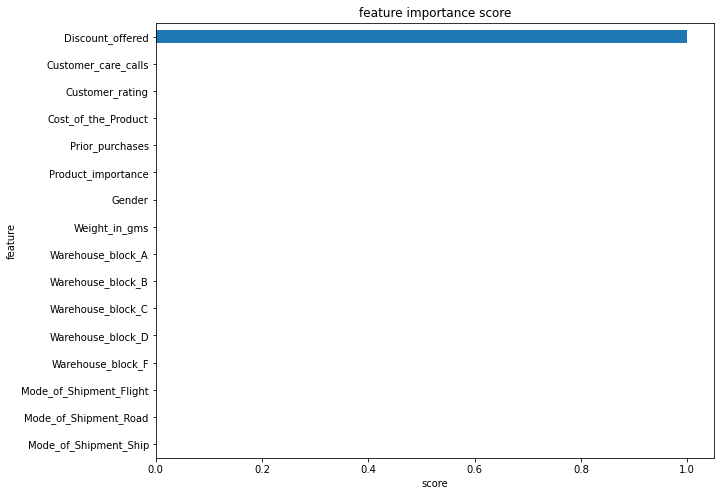

In [215]:
feat_importances = pd.Series(modelDecisionTreeClassifierGrid.best_estimator_.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score');

### 4.4 Ensemble Methods

In [202]:
# define functions 

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

#### a. Bagging: Random Forest

Accuracy (Test Set): 0.66
Precision (Test Set): 0.75
Recall (Test Set): 0.65
F1-Score (Test Set): 0.69
AUC: 0.66




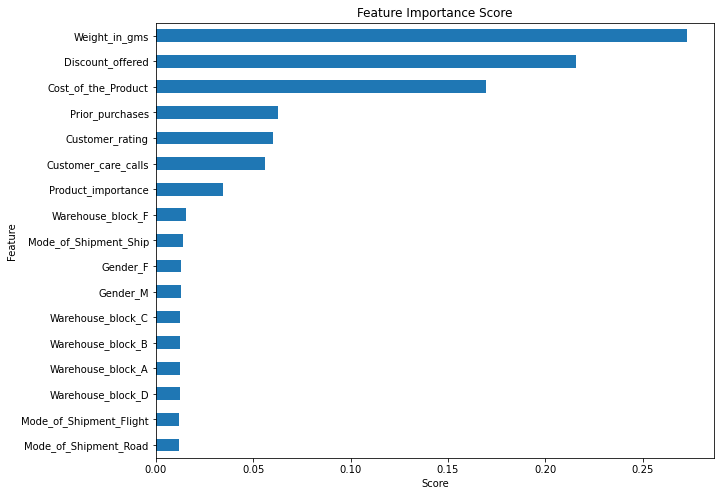

In [203]:
from sklearn.ensemble import RandomForestClassifier

# Inisiasi model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

# Prediction and Evaluation
y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)


print('\n')
# feature importance
show_feature_importance(rf)

#### Bagging: Random Forest Hyperparameter Tuning with RandomizedSearchCV

Accuracy (Test Set): 0.66
Precision (Test Set): 0.75
Recall (Test Set): 0.65
F1-Score (Test Set): 0.70
AUC: 0.67


Best n_estimators: 300
Best bootstrap: True
Best criterion: gini
Best max_depth: 100
Best min_samples_split: 2
Best min_samples_leaf: 1
Best max_features: log2
Best n_jobs: -1


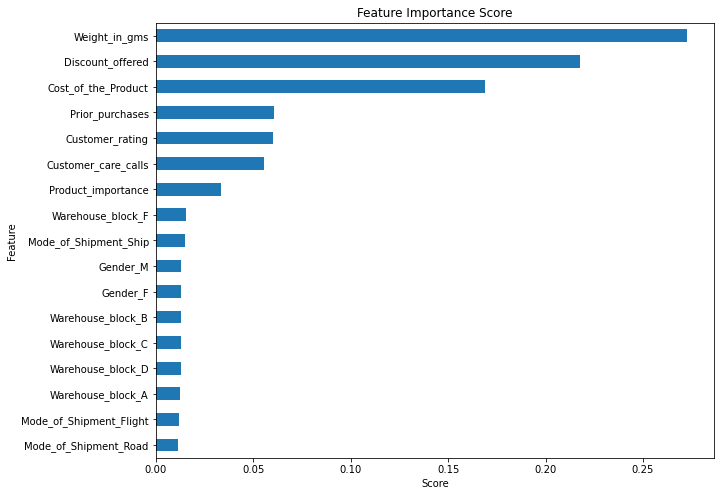

In [204]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall', n_iter=100)
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned.predict(X_test)#Check performa dari model
eval_classification(rf_tuned, y_pred, X_train, y_train, X_test, y_test)

print('\n')
# best_hyperparameters and feature importance
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)
show_feature_importance(rf_tuned.best_estimator_)

#### b. Boosting: AdaBoost

Accuracy (Test Set): 0.68
Precision (Test Set): 0.77
Recall (Test Set): 0.65
F1-Score (Test Set): 0.71
AUC: 0.69




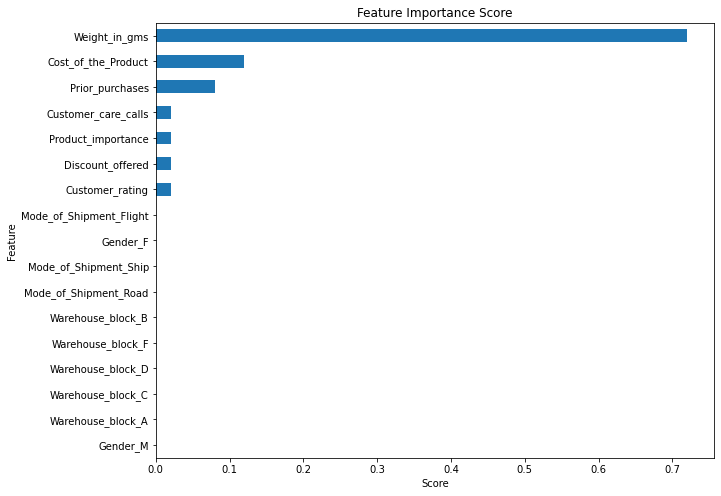

In [205]:
from sklearn.ensemble import AdaBoostClassifier

# Inisiasi model
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

# Prediction and Evaluation
y_pred = ab.predict(X_test)
eval_classification(ab, y_pred, X_train, y_train, X_test, y_test)

print('\n')
# feature importance
show_feature_importance(ab)

#### Boosting: AdaBoost Hyperparameter Tuning with RandomizedSearchCV

Accuracy (Test Set): 0.68
Precision (Test Set): 0.78
Recall (Test Set): 0.64
F1-Score (Test Set): 0.70
AUC: 0.69


Best n_estimators: 400
Best learning_rate: 0.006210526315789474
Best algorithm: SAMME.R


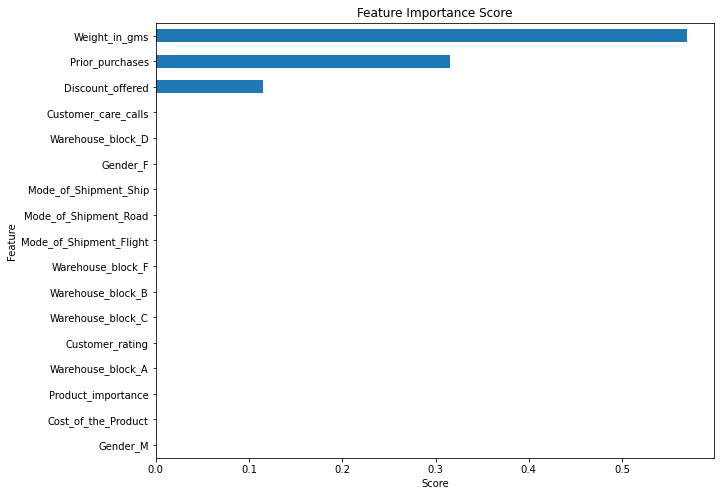

In [206]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall', n_iter=100)
ab_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = ab_tuned.predict(X_test)#Check performa dari model
eval_classification(ab_tuned, y_pred, X_train, y_train, X_test, y_test)

print('\n')
# best_hyperparameters and feature importance
show_best_hyperparameter(ab_tuned.best_estimator_, hyperparameters)
show_feature_importance(ab_tuned.best_estimator_)

#### c. Boosting: XGBoost

[15:09:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.66
Precision (Test Set): 0.75
Recall (Test Set): 0.66
F1-Score (Test Set): 0.70
AUC: 0.67




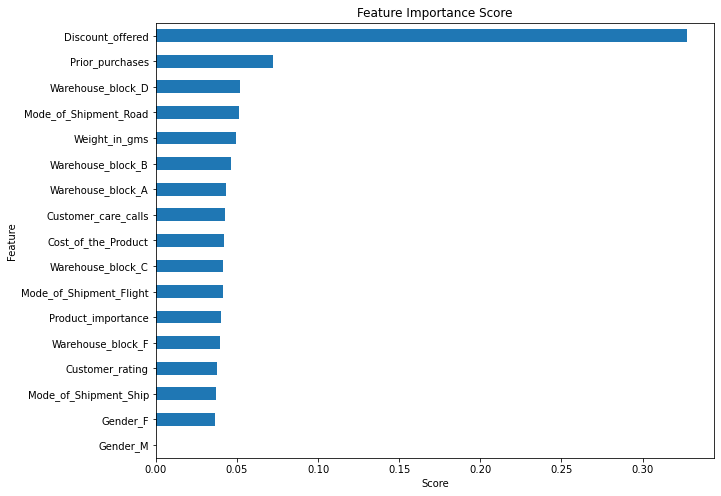

In [209]:
from xgboost import XGBClassifier

# Inisiasi model
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = xg.predict(X_test)
eval_classification(xg, y_pred, X_train, y_train, X_test, y_test)

print('\n')
# feature importance
show_feature_importance(xg)

#### Boosting: XGBoost Hyperparameter Tuning with RandomizedSearchCV

In [212]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)],

                    'objective' : ['binary:logistic','reg:logistic'],
                    'eval_metric' : ['logloss']
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall', n_iter=100)
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = xg_tuned.predict(X_test)#Check performa dari model
eval_classification(xg_tuned, y_pred, X_train, y_train, X_test, y_test)

print('\n')
# best_hyperparameters and feature importance
show_best_hyperparameter(xg_tuned.best_estimator_, hyperparameters)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.59
Recall (Test Set): 1.00
F1-Score (Test Set): 0.74
AUC: 0.50


Best max_depth: 70
Best min_child_weight: 4
Best gamma: 1.0
Best tree_method: approx
Best colsample_bytree: 0.0
Best eta: 0.32323232323232326
Best lambda: 0.2
Best alpha: 0.5
Best objective: binary:logistic
Best eval_metric: logloss


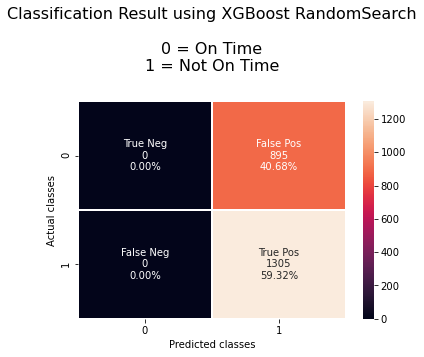

In [213]:
# Classification Result using XGBoost RandomSearch

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using XGBoost RandomSearch\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

<font color="darkblue">
    <ul><b><i>
        <li>Even though the recall value is perfect, 100%, the other evaluation metric values are very small and unbalanced as well where all the predicted results are not on time. We'll avoid an outcome like this.</li>
    </i></b></ul>
</font>

### 4.5 VotingClassifier

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

vote_model = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression()), 
        ('knn', KNeighborsClassifier(n_neighbors=39,p=2,algorithm='auto',weights='uniform')), 
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('ab', AdaBoostClassifier()),
        ('xg', XGBClassifier()),
    ], voting = 'soft')

vote_model.fit(X_train, y_train)
y_pred = vote_model.predict(X_test)
eval_classification(vote_model, y_pred, X_train, y_train, X_test, y_test)

[23:37:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.65
Precision (Test Set): 0.70
Recall (Test Set): 0.71
F1-Score (Test Set): 0.70
AUC: 0.63


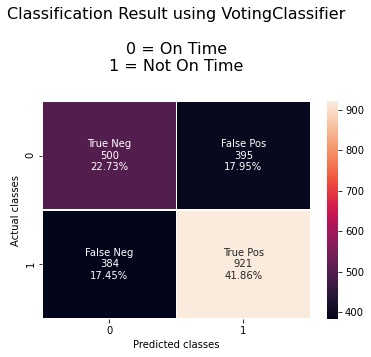

In [23]:
# Classification Result using VotingClassifier

from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_test, y_pred)
conf
# settings
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot matrix 
sns.heatmap(conf, annot = labels, fmt="", linewidths=.5) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title("Classification Result using VotingClassifier\n\n0 = On Time\n1 = Not On Time", fontsize = 16, pad = 30)
plt.show()

## 5. Merging Prediction using "K-nearest Neighbor Hyperparameter Tuning with GridSearch" to Dataframe

In [60]:
y_pred_all = modelKNeighborsClassifierGrid.predict(X)
data_final = data.copy()

# prediction column
data_final['Prediction'] = y_pred_all

# shipping cost per kg column
def ShippingCost(x):
    if x['Mode_of_Shipment'] == 'Flight':
        cost = 55000
    elif x['Mode_of_Shipment'] == 'Ship':
        cost = 49000
    else:
        cost = 20000
    return cost

data_final['Shipping_Cost_per_kg'] = data_final.apply(lambda x: ShippingCost(x), axis=1)

# shipping cost of products
data_final['Shipping_Cost_of_Products'] = data_final['Shipping_Cost_per_kg'] * (data_final['Weight_in_gms'] / 1000)

# total cost added express cost 5000
data_final['Total_Cost'] = data_final['Shipping_Cost_of_Products'] + (data_final['Cost_of_the_Product'] * 14589.15)

data_final.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Prediction,Shipping_Cost_per_kg,Shipping_Cost_of_Products,Total_Cost
0,D,Flight,4,2,177,3,low,F,44,1233,1,1,55000,67815.0,2650094.55
1,F,Flight,4,5,216,2,low,M,59,3088,1,1,55000,169840.0,3321096.40
2,A,Flight,2,2,183,4,low,M,48,3374,1,1,55000,185570.0,2855384.45
3,B,Flight,3,3,176,4,medium,M,10,1177,1,1,55000,64735.0,2632425.40
4,C,Flight,2,2,184,3,medium,F,46,2484,1,1,55000,136620.0,2821023.60


In [55]:
# calculate the cost of each prediction
data_final.groupby(['Prediction'])['Total_Cost'].sum()

Prediction
0    8.416369e+09
1    2.717906e+10
Name: Total_Cost, dtype: float64

In [67]:
# calculate the number of on time and not on time shipments
data_final.groupby(['Prediction'])['Total_Cost'].count()

Prediction
0    2448
1    8551
Name: Total_Cost, dtype: int64

In [75]:
Express_cost = 5000
recall = 83/100
late_shipment = 59.7/100
potential_churned_customer = 17/100
potential_failure_to_predict_late_shipment = 100/100 - recall

before_modification = late_shipment * potential_churned_customer
after_modification = late_shipment * potential_failure_to_predict_late_shipment * potential_churned_customer
Percentage_of_churned_customers_reduce = before_modification - after_modification

Total_revenue_from_express_shipping = 8551 * Express_cost
Total_revenue_from_product_plus_reguler_shipping = 27179060000 + 8416369000
print('Total Potential Gross Profit:',(Percentage_of_churned_customers_reduce * (Total_revenue_from_product_plus_reguler_shipping + Total_revenue_from_express_shipping)))

Total Potential Gross Profit: 3002043014.1528


<font color="darkblue">
    <ul><b><i>
        <li>The algorithm that has the best performance (83%) in evaluating the results of this prediction is K-nearest Neighbor with hyperparameter tuning using grid search</li>
        <li>It is probably influenced by non-linear data</li>
        <li>From of all the algorithms carried out, the majority of the top-5 features are:: 
            <ul>
                <li>Discount offered</li>
                <li>Weight in gms</li>
                <li>Cost of the product</li>
                <li>Prior purchases</li>
                <li>Customer rating</li>
            </ul>
        </li>
    </i></b></ul>
</font>


<font color="darkred">
    <ul><i>
        <li>From the evaluation of prediction result, we can calculate <b>number of occurence of late shipment</b> by performance is <b>83%</b></li>
        <li>Based on performance, the percentage of churned customers will decrease by <b>8,466%</b></li>
        <li>The prediction for the possible profit that will be obtained from running the model and implementing the recommendations is <b>IDR 3 billion.</b></li>
        <li>Evaluating features that affect to the arrival time would help to recommend and handle the factors affecting late shipment</li>
        <li>Since the feature that influences the most is the 'discount offered', if analysed, logically if an e-commerce company gives a lot of discounts, there will be many transactions. Of course this will affect the increasing number of product shipments on couriers or shipping expeditions which cause overload and delay in delivery. Therefore, <b>we recommend to provide a new shipping option (Express - 1 Day) for shipment predicted to be late</b></li>
    </i></ul>
</font>